In [1]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
# pl.rc("figure", facecolor="white",figsize = (8,8))
pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=False)
pl.rc('text.latex', preamble=r'\usepackage{amsmath}')
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 10)

/home/mptouzel/Dropbox/scripts/Projects/topicmod/code


In [2]:
# from lib.lib import process_data

question_label = 'carbontax_q3'

year='2019'
fig_dir='../../output/figures/'+year+'/'
data_dir='../../output/data/'+year+'/'
models_dir='../../output/stm_models/'+year+'/'
# from lib.lib import *
restypelist=['support','oppose','notsure']
max_char_length=512
fdf=pd.read_csv(data_dir+question_label+'_2019data.csv',sep='\t')

# STM

## Preprocessing

In [3]:
# question_label = 'carbontax_q3'
# fdf=pd.read_csv(data_dir+question_label+'_data.csv',sep='\t')
# restypelist=['support','oppose','notsure'] #preferred order of types for plotting
fdf.head()

,id,res,restype,lang,sex,prov,livingenv,partisanship,caruse,partyvote,agedec,resclean
0,27,We already have too much tax on gas.,oppose,EN,Male,ON,suburban,right,none,conservative,60+,alreadi much tax ga
1,28,It will likely not be effective and the scienc...,oppose,EN,Male,ON,suburban,right,driver,conservative,30-39,like effect scienc uncertain
2,29,"The people who will be paying, the average low...",oppose,EN,Female,SK,urban,none,driver,conservative,40-49,peopl pay averag low middl class peopl suffer ...
3,30,the government is making to much money,oppose,EN,Male,AB,urban,none,none,progressive,19-29,govern make much money
4,31,job killer,oppose,EN,Male,AB,smalltown,right,driver,conservative,30-39,job killer


In R, so need to interface

In [4]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.lib import grdevices
from IPython.display import Image,display


In [83]:
pandas2ri.activate()
robjects.r("library('stm')"); 
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

#need to install stm ver. 1.3.6 R-package and its dependencies
#preprocessing: tm R-package,
#stm: quanteda R-package, ...
#n.b. might have to install xml2: sudo apt-get install libxml2-dev

#redefine topicquality function to output data
robjects.r('topicQuality <- function(model, documents, xlab="Semantic Coherence", ylab="Exclusivity", labels=1:ncol(model$theta), M=10,...){ \n'+\
  'args <- asSTMCorpus(documents) \n'+\
  'documents <- args$documents \n'+\
  'if(length(model$beta$logbeta)<2){ \n'+\
  '  semcoh <- semanticCoherence(model,documents=documents, M=M) \n'+\
  '  exclusivity <- exclusivity(model, M=M) \n'+\
  '  plot(0, 0, xlab=xlab, ylab=ylab, col="white", xlim=c(min(semcoh), max(semcoh)), \n'+\
  '       ylim=c(min(exclusivity), max(exclusivity)),...) \n'+\
  '  for(i in 1:length(labels)){ \n'+\
  '    text(semcoh[i], exclusivity[i], paste("Topic", labels[i])) \n'+\
  '  } \n'+\
  '  return(list(semcoh,exclusivity)) \n'+\
  '} \n'+\
  'if(length(model$beta$logbeta)>1){ \n'+\
  '  semcoh <- semanticCoherence(model,documents=documents, M=M) \n'+\
  '  for(i in 1:length(labels)){ \n'+\
  '    print(paste("Topic", i, "has", semcoh[i], "semantic coherence")) \n'+\
  '  } \n'+\
  '} \n'+\
'}');

def pre_process_stm(resp_data, occurs_in_morethan=1):
    with localconverter(robjects.default_converter + pandas2ri.converter):
        robjects.globalenv['doc_df'] = robjects.conversion.py2rpy(resp_data)

    robjects.r("processed_corpus_temp = textProcessor(doc_df$resclean, metadata=doc_df, lowercase=TRUE)");
    robjects.r(
        'processed_corpus = prepDocuments(processed_corpus_temp$documents,'+\
                                     'processed_corpus_temp$vocab,'+\
                                     'processed_corpus_temp$meta,'+\
                                     'lower.thresh='+str(occurs_in_morethan)+') \n'+\
        'rm(processed_corpus_temp); invisible(gc())'
    );
    print()
    
def batch_run_and_save(params,plot_flag = True):
    (fig_dir,data_dir,models_dir)=params['dirs']
    for K in params['Krange']:
        for seed in params['seedlist']:
            run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
            #run inference
#             robjects.r("fitobj<-stm(documents=processed_corpus$documents[preprocessed_corpus$meta$restype="+params["res_type"]+"],vocab=processed_corpus$vocab,K="+str(K)+\
            robjects.r("fitobj<-stm(documents=processed_corpus$documents,vocab=processed_corpus$vocab,K="+str(K)+\
                ",prevalence="+params['model_str']+", max.em.its=500,data=processed_corpus$meta,seed="+str(seed)+"," +\
                "sigma.prior = "+str(params['sigma_prior'])+",verbose=FALSE"+\
            ")")
            robjects.r('save(fitobj, file = "'+models_dir+run_name+'.rda")')
            robjects.r('rm(fitobj)')
            if plot_flag:
                load_singlerun_and_plot(K,run_name,models_dir,fig_dir,data_dir)
    np.save(models_dir+params['batch_name']+'.npy',params)

def load_singlerun_and_plot(K,run_name,models_dir,fig_dir,data_dir):
    robjects.r('load(file = "'+models_dir+run_name+'.rda")')

#         #wordcloud
#         with grdevices.render_to_bytesio(grdevices.jpeg,width=1024, height=1024, res=150) as img:
#             robjects.r.cloud(robjects.globalenv['fitobj'])
#         img_obj=Image(data=img.getvalue())
#         open(fig_dir+batch_name+str(K)+"_wordcloud.jpeg", "wb").write(img_obj.data)

    #topic wordlists
    shownwords=10
    test1=robjects.r('labelTopics(fitobj,n='+str(shownwords)+')')
    topicwords=pd.Series(np.asarray(test1.rx[1][0]).reshape((shownwords,K)).T.tolist(),index=range(1,K+1))
    topicwords.index.name='topicid'
    topicwords.to_csv(data_dir+run_name+'_topicwordlists.csv')

    #prevalence plot
    with grdevices.render_to_bytesio(grdevices.jpeg,width=1024, height=1024, res=150) as img:
        robjects.r.plot(robjects.globalenv['fitobj'])
    img_obj=Image(data=img.getvalue())
    open(fig_dir+run_name+"_topicprevalence.jpeg", "wb").write(img_obj.data)
#     display(img_obj)

    #correlation matrix
    corrdata=robjects.r.topicCorr(robjects.globalenv['fitobj'])
    import scipy.cluster.hierarchy as sch
    d=sch.distance.pdist(corrdata[2])
    L=sch.linkage(d,method='complete')
    ind=sch.fcluster(L,0.5*d.max(),'distance')
    new_order = np.array([np.arange(K)[i] for i in list((np.argsort(ind)))])
    fig,ax=pl.subplots()
    p=ax.imshow(corrdata[2][:,new_order][new_order],cmap='RdBu',vmin=-1,vmax=1)
    ax.set_yticks(np.arange(K));
    ax.set_yticklabels(new_order+1);
    ax.set_xticks(np.arange(K));
    ax.set_xticklabels(new_order+1);
    ax.grid(False)
    cb=fig.colorbar(p,fraction=0.046,pad=0.04)
    cb.set_label(r'$\rho$',rotation=0)
    fig.savefig(fig_dir+run_name+"_corrmatrices.png", transparent=True,bbox_inches="tight",dpi=300)

    #correlation graph
    with grdevices.render_to_bytesio(grdevices.jpeg,width=512, height=512, res=150) as img:
        robjects.r.plot(corrdata)
    img_obj=Image(data=img.getvalue())
    open(fig_dir+run_name+"_corrgraph.jpeg", "wb").write(img_obj.data)

def load_plot_batch(params,ax):

    #load data
    qual_data={}
    for K in params['Krange']:
        qual_data[K]={}
        for seed in params['seedlist']:
            qual_data[K][seed]={}
            run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
            robjects.r('load(file = "'+models_dir+run_name+'.rda")')
            #topic quality
            datatmp=robjects.r.topicQuality(model=robjects.globalenv['fitobj'],documents=robjects.r("processed_corpus$documents"))
            qual_data[K][seed]['excl']=datatmp[1]
            qual_data[K][seed]['semcoh']=datatmp[0]
    
    #plot for each seed
    colors=pl.get_cmap('viridis',len(params['Krange']))(range(len(params['Krange'])))
    if params['batch_name'][0]=='o':
        mkr='o' 
    elif params['batch_name'][0]=='s':
        mkr='s'
    else:
        mkr='v'
    
#     ax.plot([0],[0],'k'+mkr,label=params['restype'])
    for sit,seed in enumerate(params['seedlist']):
        mean_semcoh=[]
        mean_excl=[]
        for kit,K in enumerate(params['Krange']):
            if sit==0 and params['restype']=='support':
                p=ax.plot(qual_data[K][seed]['semcoh'], qual_data[K][seed]['excl'],mkr,mew=0,color=colors[kit],label=str(K),alpha=0.5)
            else:
                p=ax.plot(qual_data[K][seed]['semcoh'], qual_data[K][seed]['excl'],mkr,mew=0,color=colors[kit],alpha=0.5)
            mean_semcoh.append(np.mean(qual_data[K][seed]['semcoh']))
            mean_excl.append(np.mean(qual_data[K][seed]['excl']))
            ax.plot([mean_semcoh[kit]], [mean_excl[kit]],mkr,color=colors[kit],mec='k',mew=1,zorder=4)
        x=np.array(mean_semcoh).reshape(-1,1)
        y=np.array(mean_excl).reshape(-1,1)
        x_scaler=preprocessing.StandardScaler().fit(x)
        y_scaler=preprocessing.StandardScaler().fit(y)
#         reg=LinearRegression().fit(x_scaler.transform(x),y_scaler.transform(y))
        reg=LinearRegression().fit(x,y)
        xvar=np.linspace(*ax.get_xlim(),10)
        ax.plot(xvar,reg.predict(xvar.reshape(-1,1)),'k-')
#         print(reg.coef_)
        ortho_slope=-1/np.mean([-0.01891469,-0.01865831,-0.02235485])
        proj_vec = np.array([1,ortho_slope])/np.sqrt(1+ortho_slope**2)
        projected_data=proj_vec.T@np.vstack((mean_semcoh,mean_excl))
        
#         ax.plot(xvar,y_scaler.inverse_transform(reg.predict(x_scaler.transform(xvar.reshape(-1,1)))),'k-')
        ax.set_xlabel('semantic coherence')
        ax.set_ylabel('exclusivity')
        ax.set_ylim(8.4,10)
        ax.set_xlim(-300,-100)
#         ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1.04,0.5))
        ax.legend(frameon=False,loc='center left',prop={'size':8},bbox_to_anchor=(1.04,0.1,1,0.6),title=r"$K$")
    np.save(data_dir+batch_name+'_batch_data.npy',qual_data)
    return projected_data

Topic quality

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 585 of 1280 terms (585 of 9840 tokens) due to frequency 
Removing 5 Documents with No Words 
Your corpus now has 1295 documents, 695 terms and 9255 tokens.
(11,)
Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 774 of 1680 terms (774 of 13472 tokens) due to frequency 
Removing 5 Documents with No Words 
Your corpus now has 1567 documents, 906 terms and 12698 tokens.
(11,)
Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 312 of 570 terms (312 of 1832 tokens) due to frequency 
Removing 10 Documents with No Words 
Your corpus now has 347 documents, 258 terms and 1520 tokens.
(11,)
Building corpus... 
Converting to

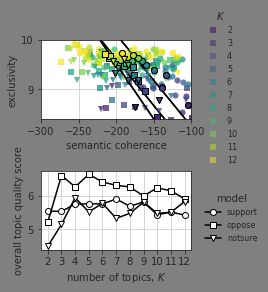

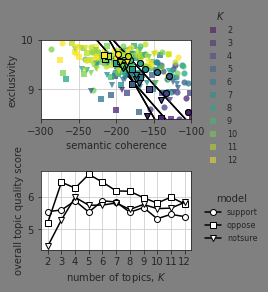

In [99]:
sig_dict={1:'1',0:'0',0.5:'half'}
for sigma in [0,1]:
    fig,ax=pl.subplots(2,1,figsize=(4,4))
    run_label='all_model_sigma'+sig_dict[sigma]
    run_label='all_model_sigma'+str(sigma)

    meta_data_names=[
                 'partisanship',
                 'partyvote',
                 'caruse',
                 'livingenv',
                 'agedec',
                 'sex',
                 'prov'
    ]
    # meta_data_names=['restype']+meta_data_names
    projdat=[]
    for rit,restype in enumerate(restypelist):
    #     restype='all'
        batch_name = restype + "_reponses_" + run_label
        params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()
        #run preprocessing on data to have access to text responses (produces 'processsed_corpus' in R)
        resp_data=fdf.loc[fdf.restype==restype,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
    #     resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)

        pre_process_stm(resp_data)
        params['restype']=restype
        projected_data=load_plot_batch(params,ax[0])
        print(projected_data.shape)
        projdat.append(projected_data)
    # fig.savefig(fig_dir+batch_name+"_excl_semcoh.pdf", transparent=True,bbox_inches="tight",dpi=300)
        mkr_set=['o','s','v'] 
        ax[1].plot(range(2,13),projected_data,'k'+mkr_set[rit]+'-',mfc="w",label=restype,mew='1')
        ax[1].set_ylabel('overall topic quality score')
        ax[1].set_xticks(range(2,13))
        ax[1].legend(frameon=False,loc='center left',prop={'size':8},bbox_to_anchor=(1.04,0.1,1,0.6),title=r"model")
        ax[1].set_xlabel(r"number of topics, $K$")
    fig.tight_layout()
    fig.savefig(fig_dir+run_label+"topic_quality.png", transparent=True,bbox_inches="tight",dpi=300)


## Top words and responses

In [111]:
year='2019'
fig_dir='../../output/figures/'+year+'/'
data_dir='../../output/data/'+year+'/'
models_dir='../../output/stm_models/'+year+'/'
fdf=pd.read_csv(data_dir+question_label+'_'+year+'data.csv',sep='\t')

Phylogenies

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 907 of 2168 terms (907 of 25144 tokens) due to frequency 
Removing 10 Documents with No Words 
Your corpus now has 3219 documents, 1261 terms and 24237 tokens.
Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 907 of 2168 terms (907 of 25144 tokens) due to frequency 
Removing 10 Documents with No Words 
Your corpus now has 3219 documents, 1261 terms and 24237 tokens.
Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 907 of 2168 terms (907 of 25144 tokens) due to frequency 
Removing 10 Documents with No Words 
Your corpus now has 3219 documents, 1261 terms and 24237 tokens.
Building corpus... 
Converting to Lower 

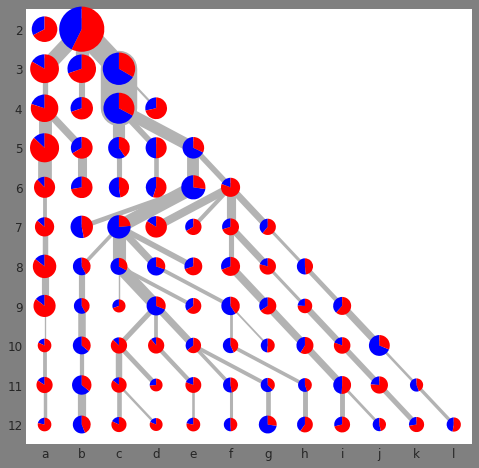

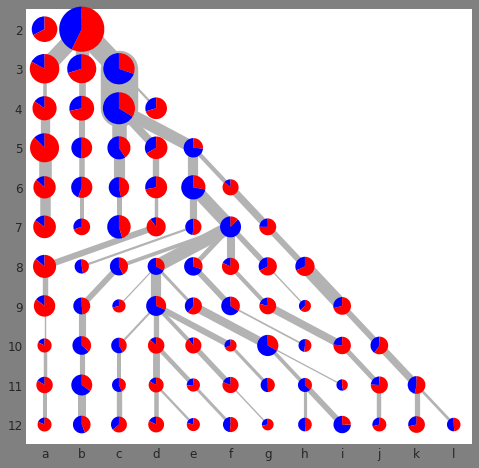

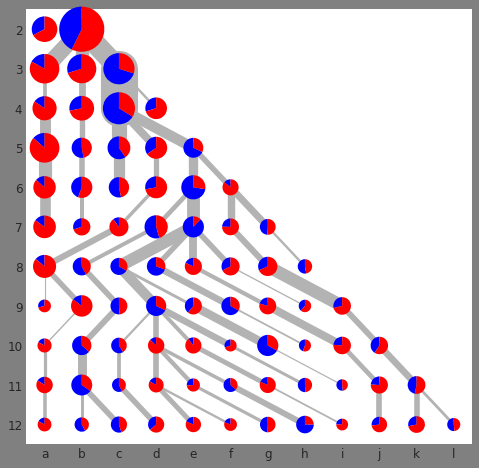

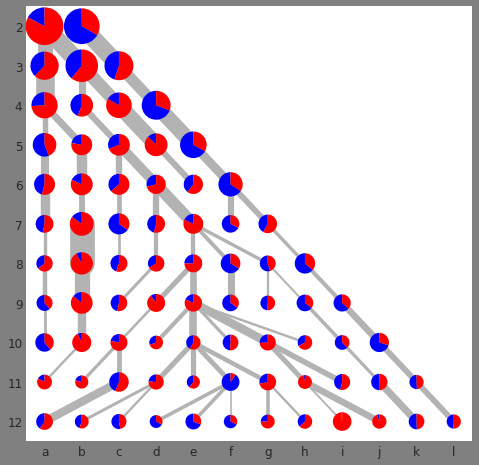

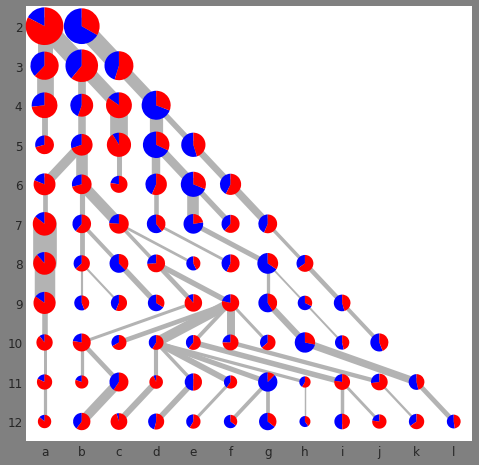

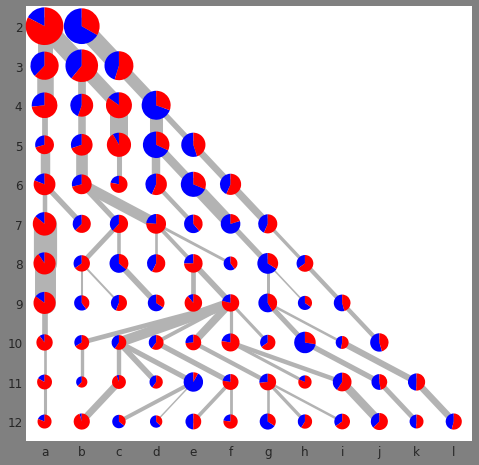

In [137]:
year='2019'
fig_dir='../../output/figures/'+year+'/'
data_dir='../../output/data/'+year+'/'
models_dir='../../output/stm_models/'+year+'/'
fdf=pd.read_csv(data_dir+question_label+'_'+year+'data.csv',sep='\t')
# sigma='0'
sig_dict={1:'1',0:'0',0.5:'half'}
for sigma in [0,0.5,1]:
    run_label='all_model_sigma'+sig_dict[sigma]
    meta_data_names=['restype',
    #                  'warmingcause',
                    'partisanship',
                 'partyvote',
                 'caruse',
                 'livingenv',
                 'agedec',
                 'sex',
                 'prov']
    restypelist=['support','oppose','notsure']
    restypelist=['all']

    #specify batch
    restype='all'
    batch_name = restype + "_reponses_" + run_label
    params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()

    #run preprocessing on data to have access to text responses (produces 'processsed_corpus' in R)
    if len(restypelist)>1:
    #     resp_data=fdf.loc[fdf.restype==restype,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
        resp_data=fdf.loc[fdf.restype==restype,['res','resclean']+meta_data_names].copy().reset_index(drop=True)
    else:
        resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
    pre_process_stm(resp_data)
    pcorp=dict(robjects.r.processed_corpus.items())

    #load specific model output
    seed=1
    linked_responses=[]
    beta_backmap=[[0,1]]
    dist_backmap=[[0,0]]
    total_thetas=[]
    support_thetas=[]
    new_inds=[[0,1]]
    for kit,K in enumerate(params['Krange']):
        run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
        robjects.r('load(file = "'+models_dir+run_name+'.rda")')
        fitobj=dict(robjects.r.fitobj.items())
    #     print(list(fitobj.keys()))
        if kit>0:
            tmp=[]
    #         tmpdist=[]
            for beta in np.exp(dict(fitobj['beta'].items())['logbeta'][0]):
                dist=np.sum(np.power(beta[np.newaxis,:]-oldbeta,2),axis=1)
    #             tmpdist.append(dist)
                tmp.append(np.argmin(dist))
            new_inds.append(np.argsort(tmp))
    #         new_dist.append(np.argsort(tmpdist))
            tmp=[]
            tmpdist=[]
            for beta in np.exp(dict(fitobj['beta'].items())['logbeta'][0])[new_inds[-1]]:
                dist=np.sum(np.power(beta[np.newaxis,:]-oldbeta,2),axis=1)
                tmpdist.append(np.min(dist))
                tmp.append(np.argmin(dist))
            beta_backmap.append(tmp)
            dist_backmap.append(tmpdist)
            oldbeta=np.exp(dict(fitobj['beta'].items())['logbeta'][0])[new_inds[-1]]
            total_theta=np.sum(fitobj['theta'],axis=0)[new_inds[-1]]
            support_theta=np.sum(fitobj['theta'][pcorp['meta']['restype'].values=='support'],axis=0)[new_inds[-1]] 

        else:
            oldbeta=np.exp(dict(fitobj['beta'].items())['logbeta'][0])
            total_theta=np.sum(fitobj['theta'],axis=0)
            support_theta=np.sum(fitobj['theta'][pcorp['meta']['restype'].values=='support'],axis=0)
        total_thetas.append(total_theta)
        support_thetas.append(support_theta)
        shownwords=10
        pd.options.display.max_colwidth=100
        test1=robjects.r('labelTopics(fitobj,n='+str(shownwords)+')')
        topicwords=pd.Series(np.asarray(test1.rx[1][0]).reshape((shownwords,K)).T.tolist(),index=range(1,K+1))
        topicwords.index.name='topicid'

        showndocs=5
        tmp=robjects.r('findThoughts(fitobj,texts='+\
               'processed_corpus$meta$res'+\
               ',n='+str(showndocs)+')')
        top_responses={}
        for topic_id,indvec in enumerate(dict(tmp.items())['index']):
            top_responses[str(topic_id+1)]=[robjects.r('processed_corpus$meta$res['+str(ind)+']')[0] for ind in indvec]

        tmp=[]
        for topic,responses in top_responses.items():
            tmp.append(topic+': '+''.join([str(word)+', ' for word in topicwords[int(topic)]])[:-2]+'<br><br>\n'+\
            ''.join([u'\u2022 "'+response+'"<br>\n' for response in responses]))
        linked_responses.append(tmp)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    fig,ax=pl.subplots()
    ax.set_ylim(3,14)
    ax.set_xlim(0,12)
    for y,row in enumerate(beta_backmap):
        for x,val in enumerate(row):
            if y>0:
                ax.plot([x+0.5,val+0.5],[14-y-0.5,14-y+0.5],'-',color=[0.7]*3,linewidth=50*(1/dist_backmap[y][x])/np.sum([1/dat for dat in dist_backmap[y]]),clip_on=False)
            datum=support_thetas[y][x]/total_thetas[y][x]
            axt = inset_axes(ax,width='60%',height='60%',bbox_to_anchor=(x/12,(10-y)/11,1/12,1/11),bbox_transform=ax.transAxes,loc=10)
            axt.pie([datum*100,(1-datum)*100],startangle=90,colors=['blue','red'],radius=np.sqrt(17*total_thetas[y][x]/np.sum(total_thetas[y])/np.pi),wedgeprops={"linewidth":0})
            axt.set_xlim([-1,1])
            axt.set_ylim([-1,1])
    ax.tick_params(axis=u'both',which=u'both',length=0)
    ax.spines[['right','top','bottom','left']].set_visible(False)
    ax.grid(False)
    ax.set_yticks(np.arange(3.5,14));
    ax.set_yticklabels([12-i for i in range(11)]);
    ax.set_xticks(np.arange(0.5,12));
    ax.set_xticklabels([i for i in 'abcdefghijkl']);
    fig.savefig(data_dir+run_name+"topresp_graphic.png", transparent=True,bbox_inches="tight",dpi=300)

    table_gen_code=\
    '''
    <style type="text/css">
    .tooltip {
      position: relative;
      display: inline-block;
      border-bottom: 1px dotted black;
    }
    .tooltip .tooltiptext {
      visibility: hidden;
      width: 600px;
      background-color: black;
      color: #fff;
      text-align: left;
      border-radius: 6px;
      padding: 5px 0;

      /* Position the tooltip */
      position: absolute;
      z-index: 1;
    }
    .tooltip:hover .tooltiptext {
      visibility: visible;
    }
    .circle { 
        align-items: center;
        width: 30px;
        height: 30px;
        line-height: 30px;
        border-radius: 100%; 
        justify-content: center; 
        border: 0px solid #000;
        color: #000;  
        text-align: center; 
        font: 18px Arial, sans-serif;
        display: flex;
    }
    table {
        border-spacing: 15px;
        '''+\
    'background: url('+run_name+'topresp_graphic.png);background-repeat:no-repeat;background-size:100% 100%}</style><table>'+\
    ''.join(['<tr>\n'+\
             '<td></td>'+\
             ''.join(['<td><div class="tooltip"><div class="circle">'+str()+'</div><span class="tooltiptext">'+linked_response+'</span></div></td>\n'\
                                 for topic_id,linked_response in enumerate([linked_responses[kit][i] for i in new_inds[kit]])])+\
             '</tr>\n'for kit in range(len(params['Krange']))])+\
    '<tr></tr></table>'
    #add nod elabel: topic_id+1
    with open(data_dir+run_name+'_test.html','w') as f:
        f.write(table_gen_code+'\n')

Extract top topic words and responses

In [118]:
# sigma='0'
sig_dict={1:'1',0:'0',0.5:'half'}
sigma=1
run_label='all_model_sigma'+sig_dict[sigma]
meta_data_names=['restype',
#                  'warmingcause',
                'partisanship',
             'partyvote',
             'caruse',
             'livingenv',
             'agedec',
             'sex',
             'prov']
restypelist=['support','oppose','notsure']
restypelist=['all']
model_str="~ "+' + '.join(meta_data_names)
#specify batch
for restype in restypelist:
    
    batch_name = restype + "_reponses_" + run_label
    params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()

    #run preprocessing on data to have access to text responses (produces 'processsed_corpus' in R)
    if len(restypelist)>1:
        resp_data=fdf.loc[fdf.restype==restype,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
    else:
        resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
    pre_process_stm(resp_data)

    #load specific model output
    for seed in [1,2]:
        for K in [7]:#5,6,7,8]:
            run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
            robjects.r('load(file = "'+models_dir+run_name+'.rda")')
            fitobj=dict(robjects.r.fitobj.items())
            print(list(fitobj.keys()))
            
            shownwords=10
            pd.options.display.max_colwidth=100
            test1=robjects.r('labelTopics(fitobj,n='+str(shownwords)+')')
            topicwords=pd.Series(np.asarray(test1.rx[1][0]).reshape((shownwords,K)).T.tolist(),index=range(1,K+1))
            topicwords.index.name='topicid'
            
            showndocs=5
            tmp=robjects.r('findThoughts(fitobj,texts='+\
                   'processed_corpus$meta$res'+\
                   ',n='+str(showndocs)+')')
            top_responses={}
            for topic_id,indvec in enumerate(dict(tmp.items())['index']):
                top_responses["topic "+str(topic_id+1)]=[robjects.r('processed_corpus$meta$res['+str(ind)+']')[0] for ind in indvec]
            #     print(robjects.r('processed_corpus$meta['+str(np.argmax(fitobj['theta'][:,topicid-1])+1)+',]$res')) #check same

            with open(data_dir+run_name+'_top_responses.txt','w') as f:
                f.write(run_name+'\n')
                f.write('model: '+model_str+'\n\n')  
                for topic,responses in top_responses.items():
                    f.write(topic+': '+''.join([str(word)+', ' for word in topicwords[int(topic[-1])]])[:-2]+'\n') 
                    f.write('\n')
                    for response in responses:
                        f.write(u'\u2022 "'+response+'"\n')
                    f.write('\n')
            with open(data_dir+run_name+'_top_responses.txt') as f:     
                print(f.read())

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 907 of 2168 terms (907 of 25144 tokens) due to frequency 
Removing 10 Documents with No Words 
Your corpus now has 3219 documents, 1261 terms and 24237 tokens.
['mu', 'sigma', 'beta', 'settings', 'vocab', 'convergence', 'theta', 'eta', 'invsigma', 'time', 'version']
all_reponses_all_model_sigma1_K_7_seed_1
model: ~ restype + partisanship + partyvote + caruse + livingenv + agedec + sex + prov

topic 1: pay, alreadi, cost, enough, peopl, know, live, much, work, afford

• "Je ne suis pas assez au courant pour me prononcer et je ne suis pas certaine que cela sera bien géré"
• "I don’ Know enough ..I don’t watch news or read paper.Only sad news now"
• "Je n'ai pas assez d'informations pour me prononcer."
• "Je ne me suis pas informé sur le sujet alors je n'en connais pas spécialement les enjeux principaux."
• "Je n'ai pas beaucoup en